 XGBoost available
DATA LOADED
Shape: (5654328, 21)
Columns: 21
 Datetime parsed
 Time features created

TARGET VARIABLE
Target: collision_flag
Class balance:
collision_flag
0    5265138
1     389190
Name: count, dtype: int64
Positive class rate: 0.0688

FEATURES SELECTED
Total features: 16

Feature list:
['region', 'borough_name', 'hour', 'dow', 'month', 'year', 'temp', 'humidity', 'precip', 'snow', 'cloudcover', 'visibility', 'heavy_rain_flag', 'freezing_risk_flag', 'conditions', 'icon']

X shape: (5654328, 16)
y shape: (5654328,)

TIME-BASED SPLIT
Strategy: Chronological split to prevent data leakage
Train:      2010-2019 (10 years)
Validation: 2020-2021 (2 years)
Test:       2022-2024 (3 years)

SPLIT SUMMARY
Train: 3,768,864 rows (0.0720 collision rate)
Val:    754,392 rows (0.0618 collision rate)
Test:  1,131,072 rows (0.0629 collision rate)
Total: 5,654,328 rows

CLASS IMBALANCE (TRAIN SET)
Negative samples: 3,497,422
Positive samples: 271,442
Imbalance ratio:  1:12.9
Scale pos 

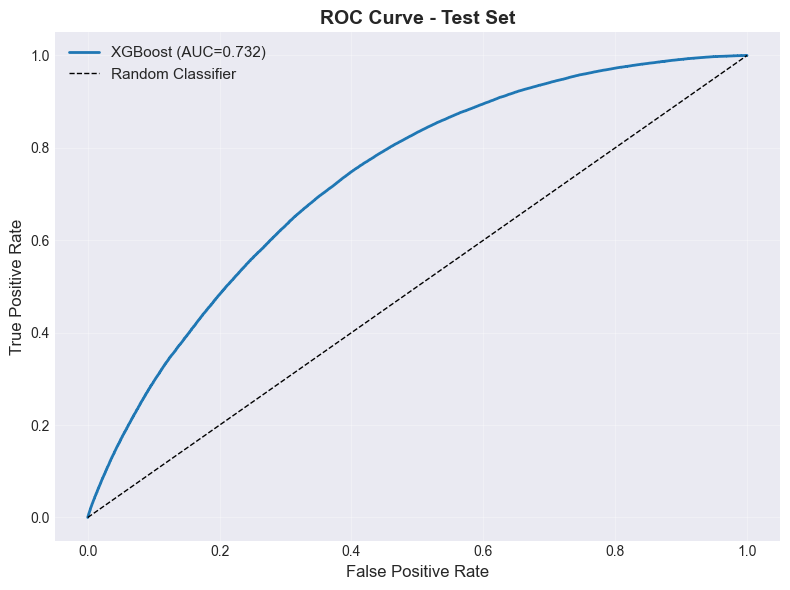

 ROC curve saved


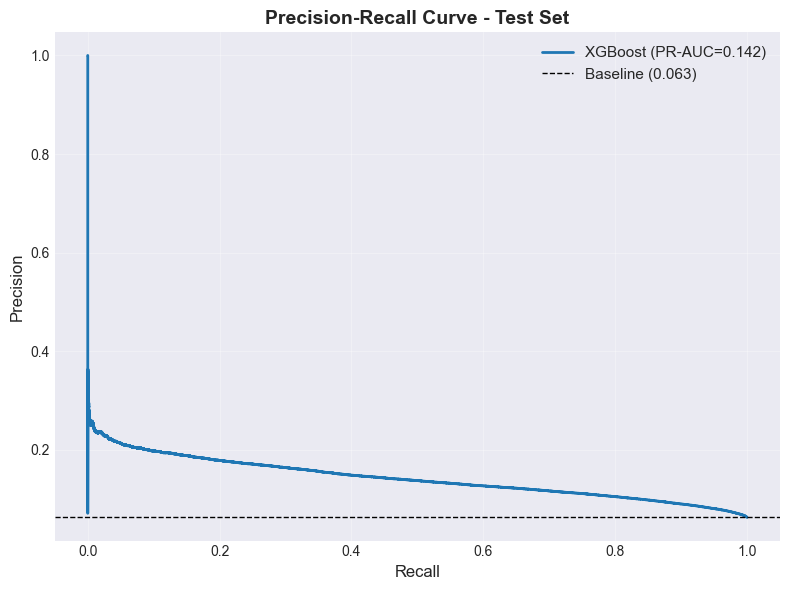

 PR curve saved


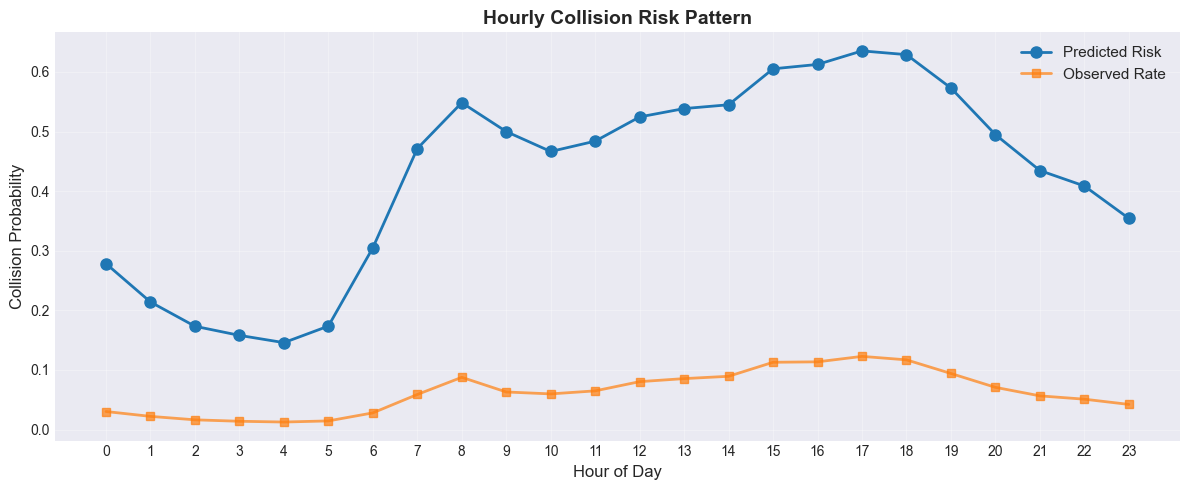

 Hourly risk plot saved

MODELLING COMPLETE 

Best Model: XGBoost
Test ROC-AUC: 0.7323
Test PR-AUC:  0.1422

Outputs saved to: figures

Files created:
  - model_comparison_validation.csv
  - final_test_metrics.csv
  - risk_by_weather.csv
  - risk_by_hour.csv
  - roc_curve.png
  - pr_curve.png
  - risk_by_hour.png

 Ready for dissertation write-up

SAVING TRAINED MODEL
 XGBoost model saved to:
  output/models\xgboost_final.pkl
  File size: 2.25 MB
 Model metadata saved to:
  output/models\model_metadata.pkl

 Model persistence complete


In [3]:
import os
os.makedirs('output/tables', exist_ok=True)
os.makedirs('output/figures', exist_ok=True)
os.makedirs('output/models', exist_ok=True)
# ============================================================
# NOTEBOOK 02: PREDICTIVE MODELLING
# Binary Classification: Hourly Collision Risk Prediction
# ============================================================

"""
RESEARCH QUESTION:
Can weather conditions predict hourly collision risk in London & Manchester?

APPROACH:
- Target: collision_flag (binary: 0/1)
- Split: Time-based (2010-2019 train, 2020-2021 val, 2022-2024 test)
- Models: Logistic Regression, Random Forest, XGBoost
- Imbalance: class_weight and scale_pos_weight
- Metrics: ROC-AUC + PR-AUC (PR-AUC critical for imbalanced data)
"""

# ============================================================
# SECTION 1: SETUP & IMPORTS
# ============================================================

# Cell 1: Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    classification_report, 
    confusion_matrix,
    precision_recall_curve, 
    roc_curve
)

# XGBoost
try:
    from xgboost import XGBClassifier
    xgb_available = True
    print(" XGBoost available")
except ImportError:
    xgb_available = False
    print(" XGBoost not available - install with: pip install xgboost")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
plt.style.use('seaborn-v0_8-darkgrid')

# ============================================================
# SECTION 2: DATA LOADING
# ============================================================

# Cell 2: Load Data
DATA_PATH = "FINAL_DATASET_FOR_TRAINING.csv"
df = pd.read_csv(DATA_PATH)

print("=" * 60)
print("DATA LOADED")
print("=" * 60)
print(f"Shape: {df.shape}")
print(f"Columns: {df.shape[1]}")

# Cell 3: Parse Datetime
df['collision_hour'] = pd.to_datetime(df['collision_hour'], utc=True, errors='coerce')

# Create time features (if not already present from R)
df['year'] = df['collision_hour'].dt.year
df['month'] = df['collision_hour'].dt.month
df['hour'] = df['collision_hour'].dt.hour
df['dow'] = df['collision_hour'].dt.dayofweek  # 0=Monday, 6=Sunday

print(" Datetime parsed")
print(f" Time features created")

# ============================================================
# SECTION 3: FEATURE ENGINEERING & SELECTION
# ============================================================

# Cell 4: Define Target
TARGET = 'collision_flag'

print("\n" + "=" * 60)
print("TARGET VARIABLE")
print("=" * 60)
print(f"Target: {TARGET}")
print(f"Class balance:\n{df[TARGET].value_counts()}")
print(f"Positive class rate: {df[TARGET].mean():.4f}")

# Cell 5: Feature Selection
feature_cols = [
    # Spatial identifiers
    'region', 
    'borough_name',
    
    # Temporal features
    'hour', 
    'dow', 
    'month', 
    'year',
    
    # Weather (continuous)
    'temp', 
    'humidity', 
    'precip', 
    'snow', 
    'cloudcover', 
    'visibility',
    
    # Hazard flags (engineered in R)
    'heavy_rain_flag', 
    'freezing_risk_flag',
    
    # Weather context (categorical)
    'conditions', 
    'icon'
]

# Keep only columns that exist
feature_cols = [c for c in feature_cols if c in df.columns]

print("\n" + "=" * 60)
print("FEATURES SELECTED")
print("=" * 60)
print(f"Total features: {len(feature_cols)}")
print(f"\nFeature list:\n{feature_cols}")

# Cell 6: Create X and y
X = df[feature_cols].copy()
y = df[TARGET].astype(int)

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

# ============================================================
# SECTION 4: TRAIN/VALIDATION/TEST SPLIT
# ============================================================

# Cell 7: Time-Based Split (NO RANDOM SPLIT)
print("\n" + "=" * 60)
print("TIME-BASED SPLIT")
print("=" * 60)
print("Strategy: Chronological split to prevent data leakage")
print("Train:      2010-2019 (10 years)")
print("Validation: 2020-2021 (2 years)")
print("Test:       2022-2024 (3 years)")

# Create split masks
train_mask = df['year'].between(2010, 2019)
val_mask = df['year'].between(2020, 2021)
test_mask = df['year'].between(2022, 2024)

# Split data
X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

# Cell 8: Split Summary
print("\n" + "=" * 60)
print("SPLIT SUMMARY")
print("=" * 60)
print(f"Train: {X_train.shape[0]:>8,} rows ({y_train.mean():.4f} collision rate)")
print(f"Val:   {X_val.shape[0]:>8,} rows ({y_val.mean():.4f} collision rate)")
print(f"Test:  {X_test.shape[0]:>8,} rows ({y_test.mean():.4f} collision rate)")
print(f"Total: {len(df):>8,} rows")

# Cell 9: Class Imbalance Metrics
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos

print("\n" + "=" * 60)
print("CLASS IMBALANCE (TRAIN SET)")
print("=" * 60)
print(f"Negative samples: {neg:,}")
print(f"Positive samples: {pos:,}")
print(f"Imbalance ratio:  1:{scale_pos_weight:.1f}")
print(f"Scale pos weight: {scale_pos_weight:.2f} (for XGBoost)")

# ============================================================
# SECTION 5: PREPROCESSING PIPELINE
# ============================================================

# Cell 10: Identify Column Types
categorical_features = [c for c in feature_cols if X_train[c].dtype == 'object']
numeric_features = [c for c in feature_cols if c not in categorical_features]

print("\n" + "=" * 60)
print("PREPROCESSING")
print("=" * 60)
print(f"Numeric features ({len(numeric_features)}):")
print(f"  {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}):")
print(f"  {categorical_features}")

# Cell 11: Build Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(with_mean=False), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), 
         categorical_features)
    ],
    remainder='drop'
)

print("\n Preprocessing pipeline created")

# ============================================================
# SECTION 6: MODEL TRAINING
# ============================================================

print("\n" + "=" * 60)
print("MODEL TRAINING")
print("=" * 60)

# Cell 12: Logistic Regression (Baseline)
print("\n[1/3] Training Logistic Regression...")
log_reg = Pipeline([
    ('prep', preprocessor),
    ('model', LogisticRegression(
        max_iter=300,
        class_weight='balanced',  # Handle imbalance
        solver='lbfgs',
        n_jobs=-1,
        random_state=42
    ))
])
log_reg.fit(X_train, y_train)
print("      Logistic Regression trained")

# Cell 13: Random Forest
print("\n[2/3] Training Random Forest...")
rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=10,
        class_weight='balanced_subsample',  # Handle imbalance
        n_jobs=-1,
        random_state=42
    ))
])
rf.fit(X_train, y_train)
print("       Random Forest trained")

# Cell 14: XGBoost
if xgb_available:
    print("\n[3/3] Training XGBoost...")
    xgb = Pipeline([
        ('prep', preprocessor),
        ('model', XGBClassifier(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective='binary:logistic',
            eval_metric='logloss',
            scale_pos_weight=scale_pos_weight,  # Handle imbalance
            random_state=42,
            n_jobs=-1,
            tree_method='hist'
        ))
    ])
    xgb.fit(X_train, y_train)
    print("      XGBoost trained")
else:
    xgb = None
    print("\n[3/3] XGBoost skipped (not available)")

print("\n All models trained")

# ============================================================
# SECTION 7: MODEL EVALUATION ON VALIDATION SET
# ============================================================

# Cell 15: Evaluation Function
def evaluate_model(name, model, X_eval, y_eval):
    """Calculate ROC-AUC and PR-AUC"""
    proba = model.predict_proba(X_eval)[:, 1]
    roc_auc = roc_auc_score(y_eval, proba)
    pr_auc = average_precision_score(y_eval, proba)
    
    print(f"\n{name}")
    print(f"  ROC-AUC: {roc_auc:.4f}")
    print(f"  PR-AUC:  {pr_auc:.4f}")
    
    return proba

# Cell 16: Validation Set Performance
print("\n" + "=" * 60)
print("VALIDATION SET RESULTS")
print("=" * 60)

log_val_proba = evaluate_model("Logistic Regression", log_reg, X_val, y_val)
rf_val_proba = evaluate_model("Random Forest", rf, X_val, y_val)
if xgb is not None:
    xgb_val_proba = evaluate_model("XGBoost", xgb, X_val, y_val)
else:
    xgb_val_proba = None

# Cell 17: Model Comparison Table
results_val = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'ROC-AUC': [
        roc_auc_score(y_val, log_val_proba),
        roc_auc_score(y_val, rf_val_proba),
        roc_auc_score(y_val, xgb_val_proba) if xgb_val_proba is not None else np.nan
    ],
    'PR-AUC': [
        average_precision_score(y_val, log_val_proba),
        average_precision_score(y_val, rf_val_proba),
        average_precision_score(y_val, xgb_val_proba) if xgb_val_proba is not None else np.nan
    ]
})

print("\n" + "=" * 60)
print("MODEL COMPARISON")
print("=" * 60)
print(results_val.to_string(index=False))

# Save comparison
import os
os.makedirs('output/tables', exist_ok=True)
results_val.to_csv('output/tables/model_comparison_validation.csv', index=False)
print("\n Saved to: model_comparison_validation.csv")

# ============================================================
# SECTION 8: THRESHOLD SELECTION
# ============================================================

# Cell 18: Find Optimal Threshold
def best_threshold_f1(y_true, proba):
    """Find threshold that maximizes F1 score"""
    precision, recall, thresholds = precision_recall_curve(y_true, proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
    
    return {
        'threshold': best_threshold,
        'precision': precision[best_idx],
        'recall': recall[best_idx],
        'f1': f1_scores[best_idx]
    }

# Cell 19: Select Best Model and Threshold
# Use XGBoost if available, otherwise Random Forest
if xgb_val_proba is not None:
    best_model = xgb
    best_val_proba = xgb_val_proba
    best_model_name = "XGBoost"
else:
    best_model = rf
    best_val_proba = rf_val_proba
    best_model_name = "Random Forest"

threshold_info = best_threshold_f1(y_val, best_val_proba)

print("\n" + "=" * 60)
print(f"OPTIMAL THRESHOLD ({best_model_name})")
print("=" * 60)
for key, val in threshold_info.items():
    print(f"{key.capitalize():12s}: {val:.4f}")

BEST_THRESHOLD = threshold_info['threshold']

# ============================================================
# SECTION 9: FINAL TEST SET EVALUATION
# ============================================================

# Cell 20: Test Set Predictions
print("\n" + "=" * 60)
print("FINAL TEST SET EVALUATION")
print("=" * 60)

test_proba = best_model.predict_proba(X_test)[:, 1]
test_preds = (test_proba >= BEST_THRESHOLD).astype(int)

# Cell 21: Test Metrics
test_roc = roc_auc_score(y_test, test_proba)
test_pr = average_precision_score(y_test, test_proba)

print(f"\n{best_model_name} Test Performance:")
print(f"  ROC-AUC: {test_roc:.4f}")
print(f"  PR-AUC:  {test_pr:.4f}")

# Cell 22: Confusion Matrix
cm = confusion_matrix(y_test, test_preds)
tn, fp, fn, tp = cm.ravel()

print(f"\nConfusion Matrix (threshold={BEST_THRESHOLD:.3f}):")
print(cm)
print(f"\nBreakdown:")
print(f"  True Negatives:  {tn:>8,}")
print(f"  False Positives: {fp:>8,}")
print(f"  False Negatives: {fn:>8,}")
print(f"  True Positives:  {tp:>8,}")

# Cell 23: Classification Report
print("\nDetailed Classification Report:")
print(classification_report(y_test, test_preds, digits=4, 
                          target_names=['No Collision', 'Collision']))

# Cell 24: Save Test Results
test_results = pd.DataFrame({
    'Metric': ['ROC-AUC', 'PR-AUC', 'Threshold', 'Precision', 'Recall', 'F1-Score'],
    'Value': [
        test_roc, 
        test_pr, 
        BEST_THRESHOLD,
        threshold_info['precision'],
        threshold_info['recall'],
        threshold_info['f1']
    ]
})
test_results.to_csv('output/tables/final_test_metrics.csv', index=False)
print("\n Test metrics saved to: final_test_metrics.csv")

# ============================================================
# SECTION 10: RISK INTERPRETATION & ANALYSIS
# ============================================================

# Cell 25: Add Predictions to Test Data
test_df = df[test_mask].copy()
test_df['predicted_risk'] = test_proba
test_df['predicted_class'] = test_preds

print("\n" + "=" * 60)
print("RISK ANALYSIS")
print("=" * 60)

# Cell 26: Risk by Weather Type
test_df['weather_type'] = np.where(
    test_df['freezing_risk_flag'] == 1, 'Freezing Risk',
    np.where(test_df['heavy_rain_flag'] == 1, 'Heavy Rain', 'Clear/Other')
)

risk_by_weather = test_df.groupby(['region', 'weather_type']).agg({
    'collision_flag': 'mean',
    'predicted_risk': 'mean',
    'borough_name': 'count'
}).reset_index()

risk_by_weather.columns = ['Region', 'Weather Type', 'Observed Rate', 
                            'Predicted Risk', 'Sample Size']

print("\n=== RISK BY WEATHER CONDITION ===")
print(risk_by_weather.round(4).to_string(index=False))

risk_by_weather.to_csv('output/tables/risk_by_weather.csv', index=False)

# Cell 27: Risk by Hour of Day
risk_by_hour = test_df.groupby('hour').agg({
    'collision_flag': 'mean',
    'predicted_risk': 'mean',
    'borough_name': 'count'
}).reset_index()

risk_by_hour.columns = ['Hour', 'Observed Rate', 'Predicted Risk', 'Sample Size']

print("\n=== RISK BY HOUR OF DAY ===")
print(risk_by_hour.round(4).to_string(index=False))

risk_by_hour.to_csv('output/tables/risk_by_hour.csv', index=False)

# Cell 28: High-Risk Hour Identification
high_risk_threshold = test_df['predicted_risk'].quantile(0.95)
high_risk_hours = test_df[test_df['predicted_risk'] >= high_risk_threshold]

print(f"\n=== HIGH RISK HOURS (Top 5%) ===")
print(f"Risk threshold:      {high_risk_threshold:.4f}")
print(f"High-risk hours:     {len(high_risk_hours):,}")
print(f"Actual coll. rate:   {high_risk_hours['collision_flag'].mean():.4f}")
print(f"Overall coll. rate:  {test_df['collision_flag'].mean():.4f}")
print(f"Risk uplift:         {high_risk_hours['collision_flag'].mean() / test_df['collision_flag'].mean():.2f}x")

# Cell 29: Risk by Region
risk_by_region = test_df.groupby('region').agg({
    'collision_flag': 'mean',
    'predicted_risk': 'mean'
}).reset_index()
risk_by_region.columns = ['Region', 'Observed Rate', 'Predicted Risk']

print("\n=== RISK BY REGION ===")
print(risk_by_region.round(4).to_string(index=False))

# ============================================================
# SECTION 11: VISUALIZATIONS (OPTIONAL)
# ============================================================
os.makedirs('output/figures', exist_ok=True)




# Cell 30: ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'{best_model_name} (AUC={test_roc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()
print(" ROC curve saved")

# Cell 31: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, test_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, linewidth=2, label=f'{best_model_name} (PR-AUC={test_pr:.3f})')
plt.axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, 
            label=f'Baseline ({y_test.mean():.3f})')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/figures/pr_curve.png', dpi=300, bbox_inches='tight')

plt.show()
print(" PR curve saved")

# Cell 32: Risk by Hour Plot
plt.figure(figsize=(12, 5))
plt.plot(risk_by_hour['Hour'], risk_by_hour['Predicted Risk'], 
         marker='o', linewidth=2, markersize=8, label='Predicted Risk')
plt.plot(risk_by_hour['Hour'], risk_by_hour['Observed Rate'], 
         marker='s', linewidth=2, markersize=6, alpha=0.7, label='Observed Rate')
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Collision Probability', fontsize=12)
plt.title('Hourly Collision Risk Pattern', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.savefig('output/figures/risk_by_hour.png', dpi=300, bbox_inches='tight')
plt.show()
print(" Hourly risk plot saved")

# ============================================================
# FINAL SUMMARY
# ============================================================

print("\n" + "=" * 60)
print("MODELLING COMPLETE ")
print("=" * 60)
print(f"\nBest Model: {best_model_name}")
print(f"Test ROC-AUC: {test_roc:.4f}")
print(f"Test PR-AUC:  {test_pr:.4f}")
print(f"\nOutputs saved to: figures")
print("\nFiles created:")
print("  - model_comparison_validation.csv")
print("  - final_test_metrics.csv")
print("  - risk_by_weather.csv")
print("  - risk_by_hour.csv")
print("  - roc_curve.png")
print("  - pr_curve.png")
print("  - risk_by_hour.png")
print("\n Ready for dissertation write-up")
# ============================================================
# SECTION 12: SAVE TRAINED MODEL (OPTIONAL)
# ============================================================

# Cell 33: Save Model with Joblib (Recommended for sklearn pipelines)
import joblib
import os

# Define save path
MODEL_DIR = 'output/models'
os.makedirs(MODEL_DIR, exist_ok=True)


# Save the best model (entire pipeline with preprocessing)
model_filename = os.path.join(MODEL_DIR, 'xgboost_final.pkl')

print("\n" + "=" * 60)
print("SAVING TRAINED MODEL")
print("=" * 60)

if xgb is not None:
    # Save XGBoost pipeline
    joblib.dump(xgb, model_filename)
    print(f" XGBoost model saved to:")
    print(f"  {model_filename}")
    
    # Get file size
    file_size = os.path.getsize(model_filename) / (1024 * 1024)  # Convert to MB
    print(f"  File size: {file_size:.2f} MB")
    
    # Save model metadata
    metadata = {
        'model_type': 'XGBoost (sklearn Pipeline)',
        'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'features': feature_cols,
        'test_roc_auc': test_roc,
        'test_pr_auc': test_pr,
        'threshold': BEST_THRESHOLD,
        'scale_pos_weight': scale_pos_weight
    }
    
    metadata_filename = os.path.join(MODEL_DIR, 'model_metadata.pkl')
    joblib.dump(metadata, metadata_filename)
    print(f" Model metadata saved to:")
    print(f"  {metadata_filename}")
    
else:
    # Save Random Forest if XGBoost unavailable
    joblib.dump(rf, model_filename.replace('xgboost', 'random_forest'))
    print(f" Random Forest model saved")

print("\n Model persistence complete")
